In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from io import StringIO

In [2]:
# Read .dep file

def df_from_dep(name:str):
    with open(name) as f:
        lines = [line.replace('D', 'E') for line in f]
    
    data = StringIO("".join(lines))
    
    df = pd.read_csv(data, sep=r'\s+', header=None)
    assert df.shape[1] == 4, f"Error: el DataFrame tiene {df.shape[1]} columnas, se esperaban 4."
    
    df.columns = ['E_MeV', 'phase_rad', 'dp/dE', 'ftan']
    
    # d1 : phaseshift (in radian)
    # d2 : numerical derivative of the phaseshift with energy, obtained with a Simpson method (in rad/MeV)
    # d3 : function of the phaseshift that enables one to infer the scattering lenth ( -tan(delta_lj)/k^(2l+1) )

    df['phase_deg'] = df['phase_rad']*180/np.pi

    return df

In [3]:
# Read .sca file

def df_from_sca(name: str):
    # Leemos el archivo, saltando las 2 primeras líneas de cabecera
    df = pd.read_csv(
        name,
        sep=r'\s+',     
        header=None,
        skiprows=2
    )

    assert df.shape[1] == 6, (
        f"Error: el DataFrame tiene {df.shape[1]} columnas, se esperaban 6."
    )

    df.columns = [
        'Energy_MeV',       # (MeV)
        'k_fm_inv',         # (fm^{-1})
        'eta',              # adimensional
        'phase_deg',        # (degrees)
        'cross_section_b',  # (barn)
        'S_factor_MeVb'     # (MeV·barn)
    ]

    df['S_factor_KeVb'] = df['S_factor_MeVb']*1e3

    return df

GekX = df_from_sca("Li7WS_GekX.sca")
EekX = df_from_sca("Li7WS_EekX.sca")
GekX

,Energy_MeV,k_fm_inv,eta,phase_deg,cross_section_b,S_factor_MeVb,S_factor_KeVb
0,0.01,0.02869,4.13080,-1.840210e-09,3.776380e-14,0.000071,0.070633
1,0.02,0.04057,2.92092,-3.665530e-06,3.738180e-11,0.000070,0.069847
2,0.03,0.04969,2.38492,-1.058020e-04,7.148790e-10,0.000069,0.069057
3,0.04,0.05737,2.06540,-7.835670e-04,3.945810e-09,0.000068,0.068259
4,0.05,0.06415,1.84735,-3.067040e-03,1.227640e-08,0.000067,0.067453
...,...,...,...,...,...,...,...
495,4.96,0.63889,0.18548,-7.291650e+01,1.211120e-06,0.000019,0.019266
496,4.97,0.63953,0.18529,-7.301160e+01,1.209700e-06,0.000019,0.019260
497,4.98,0.64017,0.18511,-7.310660e+01,1.208280e-06,0.000019,0.019253
498,4.99,0.64081,0.18492,-7.320150e+01,1.206860e-06,0.000019,0.019247


Text(0, 0.5, 'S-factor / keV b')

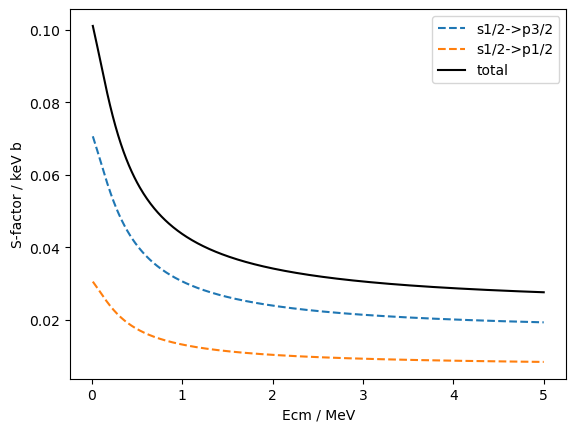

In [4]:
plt.plot(GekX["Energy_MeV"], GekX["S_factor_KeVb"], '--', label='s1/2->p3/2')
plt.plot(EekX["Energy_MeV"], EekX["S_factor_KeVb"], '--', label='s1/2->p1/2')
plt.plot(EekX["Energy_MeV"], GekX["S_factor_KeVb"]+EekX["S_factor_KeVb"], 'k', label='total')
EekX["Energy_MeV"]
plt.legend()
plt.xlabel("Ecm / MeV")
plt.ylabel("S-factor / keV b")
# plt.yscale('log')

(0.0, 1.0)

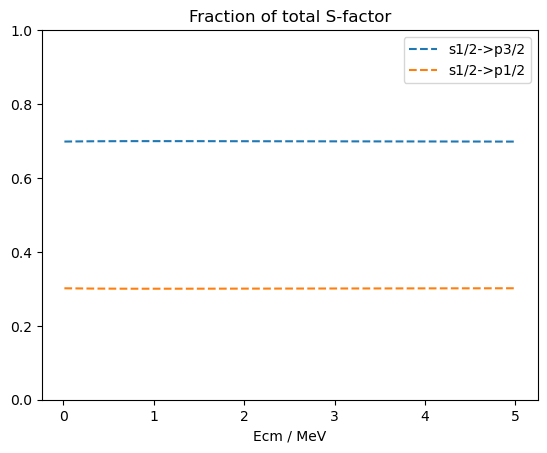

In [5]:
TekX = GekX["S_factor_KeVb"]+EekX["S_factor_KeVb"]
plt.plot(GekX["Energy_MeV"], GekX["S_factor_KeVb"]/TekX, '--', label='s1/2->p3/2')
plt.plot(EekX["Energy_MeV"], EekX["S_factor_KeVb"]/TekX, '--', label='s1/2->p1/2')

plt.legend()
plt.xlabel("Ecm / MeV")
plt.title("Fraction of total S-factor")
plt.ylim((0,1))

# Manual S factor extraction 

In [7]:
ma = 4.002603254
mt = 3.016049281
mu = (ma*mt)/(ma+mt)

df_Griffiths = pd.DataFrame({
    'EN_MEV': [0.35, 0.43, 0.56, 0.61, 0.86, 1.11, 1.32, 1.52, 1.83],
    'DATA_MB': [0.5E-04, 0.95E-04, 0.143E-03, 0.155E-03, 0.2E-03, 0.315E-03, 0.358E-03, 0.4E-03, 0.44E-03],
    'ERR-T_MB': [0.15E-04, 0.25E-04, 0.3E-04, 0.4E-04, 0.5E-04, 0.6E-04, 0.6E-04, 0.8E-04, 0.9E-04],
    '1DATA_B*KEV': [0.0615, 0.0730, 0.0690, 0.0645, 0.0530, 0.0045, 0.0632, 0.0645, 0.064]
})
df_Griffiths
# df_Griffiths['Sommerfeld1'] = np.log( df_Griffiths['1DATA_B*KEV']/df_Griffiths['DATA_MB']/(df_Griffiths['EN_MEV']) )/(2*np.pi) # /mu*ma
df_Griffiths['Sommerfeld2'] =  0.1574854051886 * 2*1* np.sqrt(mu/df_Griffiths['EN_MEV'])
# df_Griffiths['Sfactor_MB*MEV'] = df_Griffiths['DATA_MB'] * df_Griffiths['EN_MEV'] * np.exp(2*np.pi * df_Griffiths['Sommerfeld2'])
df_Griffiths['cs'] = df_Griffiths['1DATA_B*KEV']/df_Griffiths['EN_MEV']/np.exp(2*np.pi * df_Griffiths['Sommerfeld2'])

df_Brune = pd.DataFrame({
    'EN-CM_KEV': [5.5083E+01, 7.4340E+01, 9.3510E+01, 1.1243E+02, 1.5912E+02, 2.0073E+02, 2.4477E+02, 2.8693E+02, 3.3125E+02, 3.7306E+02, 4.1742E+02, 5.0599E+02,
                 5.5955E+02, 6.7917E+02, 8.4978E+02, 1.0212E+03, 1.1894E+03],
    'DATA_B*KEV': [9.2869E-02, 8.8675E-02, 8.5454E-02, 8.5480E-02, 8.0018E-02, 7.4788E-02, 7.3096E-02, 6.8679E-02, 6.8171E-02, 6.4657E-02, 6.2534E-02, 6.2555E-02,
                  6.2396E-02, 5.9248E-02, 6.0480E-02, 6.5536E-02, 6.7765E-02],
    'DATA-ERR_B*KEV': [  6.2146E-03, 4.2274E-03, 3.3215E-03, 2.2601E-03, 2.1137E-03, 1.3889E-03, 1.2489E-03, 1.1399E-03, 1.3165E-03, 1.0261E-03, 3.6422E-04,
                       9.4227E-04, 1.8233E-03, 6.3766E-04, 7.0857E-04, 2.1271E-03, 2.3297E-03],
})
df_Brune

df_Bystritsky = pd.DataFrame({
    'EN-CM_KEV': [15.7],
    'DATA_B*KEV': [0.091],
    'ERR-S_B*KEV': [0.032],
    'ERR-SYS_B*KEV': [0.011]
})
df_Bystritsky

df_Holmgren = pd.DataFrame({
    'EN_MEV': [0.484, 0.719, 0.940, 1.134, 1.328], # Alpha energy
    'DATA_MICRO-B': [6.39E-01, 9.48E-01, 1.10E+00, 1.20E+00, 1.30E+00],
    'ERR-S_MICRO-B': [3.51E-02, 9.34E-02, 9.26E-02, 5.00E-02, 7.16E-02],
})
df_Holmgren
df_Holmgren['EN-CM_MEV'] = df_Holmgren['EN_MEV'] * mu / ma
df_Holmgren['Sommerfeld'] = 0.1574854051886 * 2*1* np.sqrt(mu/df_Holmgren['EN-CM_MEV'])
df_Holmgren['Sfactor_MB*MEV'] = df_Holmgren['DATA_MICRO-B']*1e-3 * df_Holmgren['EN_MEV'] * np.exp(2*np.pi* df_Holmgren['Sommerfeld'] )
df_Holmgren['Sfactor-ERR_MB*MEV'] = df_Holmgren['ERR-S_MICRO-B']*1e-3 * df_Holmgren['EN_MEV'] * np.exp(2*np.pi* df_Holmgren['Sommerfeld'] )


df_Schroder = pd.DataFrame({
    'EN-CM_MEV': [0.0779, 0.0932, 0.1208, 0.1422, 0.1635, 0.185, 0.2125, 0.2279, 0.2463, 0.28, 0.2891, 0.2984, 0.3229, 0.3381, 0.3658, 0.3842,
     0.3965, 0.4242, 0.4486, 0.464, ],
    'DATA_MB*MEV': [0.1352, 0.1276, 0.1239, 0.1213, 0.0974, 0.0999, 0.0861, 0.0961, 0.0848, 0.0898, 0.0759, 0.0809, 0.0797, 0.0658, 0.0821, 0.0834,
                    0.0884, 0.0921, 0.0783, 0.082],
    'DATA-ERR_MB*MEV': [0.0075, 0.0063, 0.0176, 0.0063, 0.0088, 0.0063, 0.0063, 0.0063, 0.0038, 0.0088, 0.0075, 0.0075, 0.0075, 0.0113, 0.0075, 0.0063, 0.0063,
                        0.0063, 0.0075, 0.0075],
})
df_Schroder

df_Tokimoto = pd.DataFrame({
    'EN-CM_MEV': [0.10000, 0.15000, 0.20000, 0.25000, 0.30000, 0.35000, 0.40000, 0.45000, 0.50000],
    '1DATA_B*KEV': [0.11940, 0.056793, 0.062277, 0.059286, 0.054647, 0.047107, 0.054005, 0.049821, 0.055512],
    '1DATA-ERR_B*KEV': [0.032921, 0.011170, 0.0073743, 0.0064109, 0.0050578, 0.0044988, 0.0043675, 0.0047228, 0.0046550 ],
    '2DATA_B*KEV': [0.1686371, 0.1268339, 0.1125868, 0.09715452, 0.06960442, 0.07552728, 0.07141581, 0.06970487, 0.06064004 ],
    '2DATA-ERR_B*KEV': [0.03187356, 0.01282016, 0.00935439, 0.00687489, 0.00525669, 0.00547622, 0.00484125, 0.00515533, 0.00454367],
})
df_Tokimoto

df_Utsunomiya = pd.DataFrame({
    'e_KEV': [80, 130, 180, 230, 280, 330, 380, 430, 480, 530, 580, 630, 680, 730, 780, 830, 880, 930, 980], 
    'S(e)_B*KEV': [0.35, 0.15, 0.11, 0.095, 0.082, 0.071, 0.069, 0.064, 0.063, 0.060, 0.059, 0.057, 0.054, 0.053, 0.056, 0.055, 0.054, 0.056, 0.059], 
    'Error-plus_B*KEV': [0.14, 0.04, 0.01, 0.007, 0.011, 0.014, 0.008, 0.007, 0.006, 0.003, 0.004, 0.005, 0.005, 0.007, 0.009, 0.007, 0.007, 0.011, 0.009], 
    'Error-minus_B*KEV': [0.13, 0.05, 0.012, 0.010, 0.010, 0.012, 0.006, 0.006, 0.005, 0.005, 0.005, 0.004, 0.004, 0.009, 0.009, 0.007, 0.007, 0.010, 0.009], 
})
df_Utsunomiya


df_Holmgren
df_Griffiths # Sommerfeld don't macth ????

,EN_MEV,DATA_MB,ERR-T_MB,1DATA_B*KEV,Sommerfeld2,cs
0,0.35,0.000050,0.000015,0.0615,0.698232,0.002185
1,0.43,0.000095,0.000025,0.0730,0.629941,0.003243
2,0.56,0.000143,0.000030,0.0690,0.552001,0.003840
3,0.61,0.000155,0.000040,0.0645,0.528894,0.003811
4,0.86,0.000200,0.000050,0.0530,0.445435,0.003752
5,1.11,0.000315,0.000060,0.0045,0.392078,0.000345
6,1.32,0.000358,0.000060,0.0632,0.359540,0.005001
7,1.52,0.000400,0.000080,0.0645,0.335052,0.005169
8,1.83,0.000440,0.000090,0.0640,0.305357,0.005134


Text(0.5, 1.0, 'Tokimoto Fig 1')

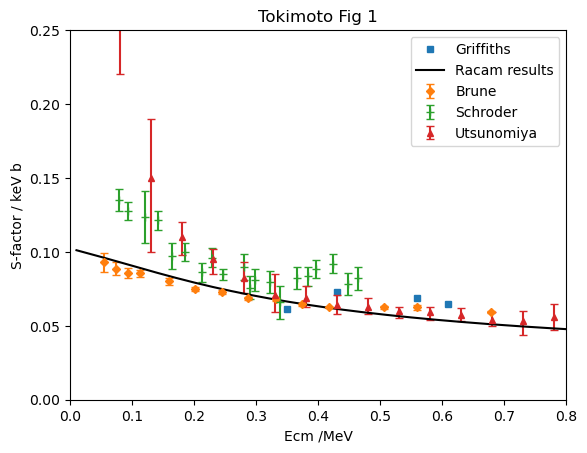

In [8]:
# Tokimoto Fig 1
plt.plot(df_Griffiths['EN_MEV'], df_Griffiths['1DATA_B*KEV'], 's', markersize=5, label='Griffiths') # errors
# plt.errorbar(df_Griffiths['EN_MEV'], 
#              df_Griffiths['1DATA_B*KEV'], 
#              yerr=np.vstack([np.array(df_Griffiths['1DATA_B*KEV'])*0.27]*2), 
#              fmt='s', markersize=5, capsize=3, label='Griffiths')

plt.errorbar(df_Brune['EN-CM_KEV']*1e-3, 
             df_Brune['DATA_B*KEV'], 
             yerr=np.vstack([np.array(df_Brune['DATA-ERR_B*KEV'])]*2), 
             fmt='D', markersize=4, capsize=3, label='Brune')

plt.errorbar(df_Schroder['EN-CM_MEV'], 
             df_Schroder['DATA_MB*MEV'], 
             yerr=np.vstack([np.array(df_Schroder['DATA-ERR_MB*MEV'])]*2), 
             fmt='+', markersize=6, capsize=3, label='Schroder')

plt.errorbar(df_Utsunomiya['e_KEV']*1e-3, 
             df_Utsunomiya['S(e)_B*KEV'], 
             yerr=np.vstack([
                 np.array(df_Utsunomiya['Error-minus_B*KEV']), 
                 np.array(df_Utsunomiya['Error-plus_B*KEV']), 
             ]), 
             fmt='^', markersize=5, capsize=3, label='Utsunomiya')

plt.plot(EekX["Energy_MeV"], TekX, 'k', label='Racam results')

plt.legend()
plt.xlabel("Ecm /MeV")
plt.ylabel("S-factor / keV b")
plt.ylim((0.00, 0.25))
plt.xlim((0.00, 0.8))
plt.title("Tokimoto Fig 1")


Text(0.5, 1.0, 'Bystritsky Fig 1')

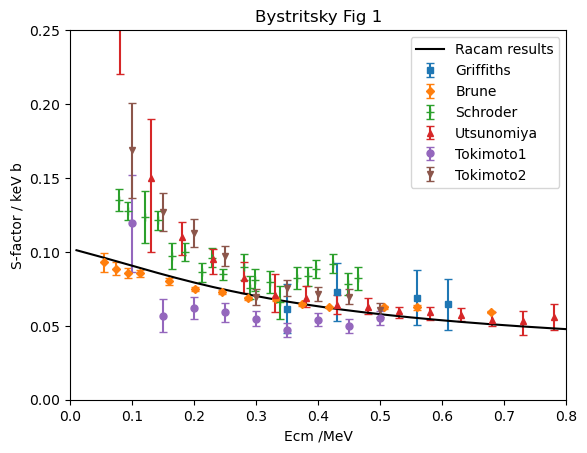

In [26]:
# Bystritsky Fig 1
# plt.plot(df_Griffiths['EN_MEV'], df_Griffiths['1DATA_B*KEV'], 's', markersize=5, label='Griffiths') # errors

plt.errorbar(df_Griffiths['EN_MEV'], 
             df_Griffiths['1DATA_B*KEV'], 
             yerr=np.vstack([np.array(df_Griffiths['1DATA_B*KEV'])*0.27]*2), 
             fmt='s', markersize=4, capsize=3, label='Griffiths')

plt.errorbar(df_Brune['EN-CM_KEV']*1e-3, 
             df_Brune['DATA_B*KEV'], 
             yerr=np.vstack([np.array(df_Brune['DATA-ERR_B*KEV'])]*2), 
             fmt='D', markersize=4, capsize=3, label='Brune')

plt.errorbar(df_Schroder['EN-CM_MEV'], 
             df_Schroder['DATA_MB*MEV'], 
             yerr=np.vstack([np.array(df_Schroder['DATA-ERR_MB*MEV'])]*2), 
             fmt='+', markersize=6, capsize=3, label='Schroder')

plt.errorbar(df_Utsunomiya['e_KEV']*1e-3, 
             df_Utsunomiya['S(e)_B*KEV'], 
             yerr=np.vstack([
                 np.array(df_Utsunomiya['Error-minus_B*KEV']), 
                 np.array(df_Utsunomiya['Error-plus_B*KEV']), 
             ]), 
             fmt='^', markersize=5, capsize=3, label='Utsunomiya')

plt.errorbar(df_Tokimoto['EN-CM_MEV'], 
             df_Tokimoto['1DATA_B*KEV'], 
             yerr=np.vstack([np.array(df_Tokimoto['1DATA-ERR_B*KEV'])]*2), 
             fmt='o', markersize=5, capsize=3, label='Tokimoto1')

plt.errorbar(df_Tokimoto['EN-CM_MEV'], 
             df_Tokimoto['2DATA_B*KEV'], 
             yerr=np.vstack([np.array(df_Tokimoto['2DATA-ERR_B*KEV'])]*2), 
             fmt='v', markersize=5, capsize=3, label='Tokimoto2')

plt.plot(EekX["Energy_MeV"], TekX, 'k', label='Racam results')

plt.legend()
plt.xlabel("Ecm /MeV")
plt.ylabel("S-factor / keV b")
plt.ylim((0.00, 0.25))
plt.xlim((0.00, 0.8))
plt.title("Bystritsky Fig 1")

## !!! Here Griffiths points closely resemble those from Fig 1 Tokimoto.
#### Let's take 27% error as Griffiths S-factor errors

Text(0.5, 1.0, 'Bystritsky Fig 11')

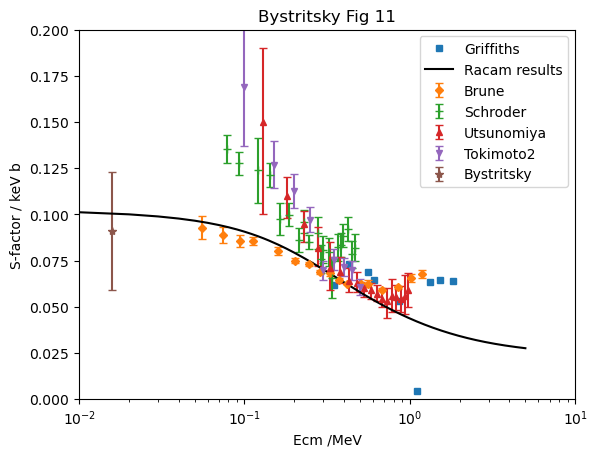

In [10]:
# Bystritsky Fig 11
plt.plot(df_Griffiths['EN_MEV'], df_Griffiths['1DATA_B*KEV'], 's', markersize=5, label='Griffiths') # errors

plt.errorbar(df_Brune['EN-CM_KEV']*1e-3, 
             df_Brune['DATA_B*KEV'], 
             yerr=np.vstack([np.array(df_Brune['DATA-ERR_B*KEV'])]*2), 
             fmt='D', markersize=4, capsize=3, label='Brune')

plt.errorbar(df_Schroder['EN-CM_MEV'], 
             df_Schroder['DATA_MB*MEV'], 
             yerr=np.vstack([np.array(df_Schroder['DATA-ERR_MB*MEV'])]*2), 
             fmt='+', markersize=6, capsize=3, label='Schroder')

plt.errorbar(df_Utsunomiya['e_KEV']*1e-3, 
             df_Utsunomiya['S(e)_B*KEV'], 
             yerr=np.vstack([
                 np.array(df_Utsunomiya['Error-minus_B*KEV']), 
                 np.array(df_Utsunomiya['Error-plus_B*KEV']), 
             ]), 
             fmt='^', markersize=5, capsize=3, label='Utsunomiya')

# plt.errorbar(df_Tokimoto['EN-CM_MEV'], 
#              df_Tokimoto['1DATA_B*KEV'], 
#              yerr=np.vstack([np.array(df_Tokimoto['1DATA-ERR_B*KEV'])]*2), 
#              fmt='o', markersize=5, capsize=3, label='Tokimoto1')

plt.errorbar(df_Tokimoto['EN-CM_MEV'], 
             df_Tokimoto['2DATA_B*KEV'], 
             yerr=np.vstack([np.array(df_Tokimoto['2DATA-ERR_B*KEV'])]*2), 
             fmt='v', markersize=5, capsize=3, label='Tokimoto2')

plt.errorbar(df_Bystritsky['EN-CM_KEV']*1e-3, 
             df_Bystritsky['DATA_B*KEV'], 
             yerr=np.vstack([np.array(df_Bystritsky['ERR-S_B*KEV'])]*2), 
             fmt='*', markersize=6, capsize=3, label='Bystritsky')

plt.plot(EekX["Energy_MeV"], TekX, 'k', label='Racam results')

plt.xscale('log')
plt.legend()
plt.xlabel("Ecm /MeV")
plt.ylabel("S-factor / keV b")
plt.ylim((0.00, 0.2))
plt.xlim((0.01, 10))
plt.title("Bystritsky Fig 11")

Text(0.5, 1.0, 'All data in Bystritsky Fig 11 style')

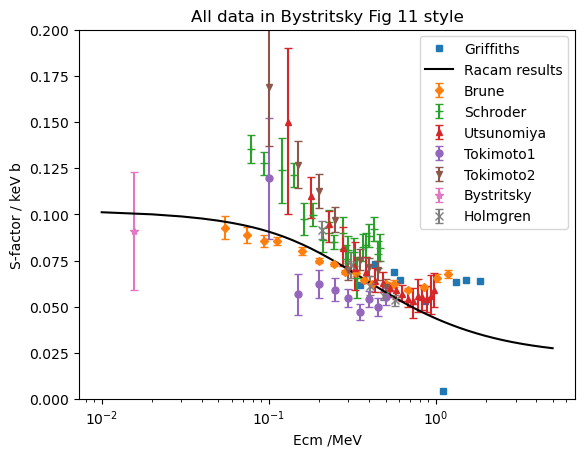

In [11]:
%matplotlib inline
# %matplotlib qt
# All of them
plt.plot(df_Griffiths['EN_MEV'], df_Griffiths['1DATA_B*KEV'], 's', markersize=5, label='Griffiths') # errors

plt.errorbar(df_Brune['EN-CM_KEV']*1e-3, 
             df_Brune['DATA_B*KEV'], 
             yerr=np.vstack([np.array(df_Brune['DATA-ERR_B*KEV'])]*2), 
             fmt='D', markersize=4, capsize=3, label='Brune')

plt.errorbar(df_Schroder['EN-CM_MEV'], 
             df_Schroder['DATA_MB*MEV'], 
             yerr=np.vstack([np.array(df_Schroder['DATA-ERR_MB*MEV'])]*2), 
             fmt='+', markersize=6, capsize=3, label='Schroder')

plt.errorbar(df_Utsunomiya['e_KEV']*1e-3, 
             df_Utsunomiya['S(e)_B*KEV'], 
             yerr=np.vstack([
                 np.array(df_Utsunomiya['Error-minus_B*KEV']), 
                 np.array(df_Utsunomiya['Error-plus_B*KEV']), 
             ]), 
             fmt='^', markersize=5, capsize=3, label='Utsunomiya')

plt.errorbar(df_Tokimoto['EN-CM_MEV'], 
             df_Tokimoto['1DATA_B*KEV'], 
             yerr=np.vstack([np.array(df_Tokimoto['1DATA-ERR_B*KEV'])]*2), 
             fmt='o', markersize=5, capsize=3, label='Tokimoto1')

plt.errorbar(df_Tokimoto['EN-CM_MEV'], 
             df_Tokimoto['2DATA_B*KEV'], 
             yerr=np.vstack([np.array(df_Tokimoto['2DATA-ERR_B*KEV'])]*2), 
             fmt='v', markersize=5, capsize=3, label='Tokimoto2')

plt.errorbar(df_Bystritsky['EN-CM_KEV']*1e-3, 
             df_Bystritsky['DATA_B*KEV'], 
             yerr=np.vstack([np.array(df_Bystritsky['ERR-S_B*KEV'])]*2), 
             fmt='*', markersize=6, capsize=3, label='Bystritsky')


# plt.plot(df_Holmgren['EN-CM_MEV'], df_Holmgren['Sfactor_MB*MEV'], 'x', markersize=4, label='Holmgren')

plt.errorbar(df_Holmgren['EN-CM_MEV'],
             df_Holmgren['Sfactor_MB*MEV'], 
             yerr=np.vstack([np.array(df_Holmgren['Sfactor-ERR_MB*MEV'])]*2), 
             fmt='x', markersize=6, capsize=3, label='Holmgren')

plt.plot(EekX["Energy_MeV"], TekX, 'k', label='Racam results')

plt.xscale('log')
plt.legend()
plt.xlabel("Ecm /MeV")
plt.ylabel("S-factor / keV b")
plt.ylim((0.00, 0.2))
plt.title("All data in Bystritsky Fig 11 style")